#Assignment 6


In [ ]:
import torch 
import torch.nn as nn
import torchvision
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/')

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

seed=121

torch.manual_seed(seed)

print("Using Cuda : ", use_cuda)


Using Cuda :  True


In [ ]:
#Get the MNIST dataset

train_dataset =  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))


test_dataset =  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# #define Data loaders

# Batch_size = 128

# dataloader_args= dict(shuffle=True, batch_size=Batch_size,num_workers=4, pin_memory=True ) if use_cuda else dict(shuffle=True, batch_size=Batch_size)

# train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)



In [ ]:
#data Statistics
train = train_dataset.train_data
train = train_dataset.transform(train.numpy())


print("Train data statistics : ")

print('#    Numpy shape :' ,train.numpy().shape)
print('#    Tensor shape :', train_dataset.train_data.size())
print('#    Max :', torch.max(train))
print('#    min :', torch.min(train))
print('#    std:', torch.std(train))
print('#    var:', torch.var(train))
print('#    Mean:', torch.mean(train))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train data statistics : 
#    Numpy shape : (28, 60000, 28)



#    Tensor shape : torch.Size([60000, 28, 28])
#    Max : tensor(2.8215)
#    min : tensor(-0.4242)
#    std: tensor(1.0000)
#    var: tensor(1.0001)
#    Mean: tensor(-0.0002)


In [ ]:
# #View Images
# %matplotlib inline
# import matplotlib.pyplot as plt
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)

# print('Image : ',example_data.shape)
# print('Target : ',example_targets.shape)
# plt.imshow(example_data[1][0], cmap='gray_r')
# plt.title("{}".format(example_targets[1]),color='red')

# fig = plt.figure()
# for i in range(60):
#   plt.subplot(6,10,i+1)
#   #plt.tight_layout()
#   plt.imshow(example_data[i][0].numpy().squeeze(), cmap='gray', interpolation='none')
#   plt.title("{}".format(example_targets[i]),color='red')
#   plt.axis('off')


#Architecture

In [ ]:

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      #Input Block 1
      self.Conv1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU()          
      ) # ouput - 26

      self.BatchN1 = nn.BatchNorm2d(10)

      self.GBN1 = GhostBatchNorm(10,2)

      # Convolution Block 1
      self.Conv2 = nn.Sequential(
          nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU()
      ) # ouput - 24

      self.BatchN2 = nn.BatchNorm2d(16)

      self.GBN2 = GhostBatchNorm(16,2)

      # Transistion Block 1
      self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
      self.Conv3 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          nn.ReLU()
      ) # ouput - 12

      self.BatchN3 = nn.BatchNorm2d(10)

      self.GBN3 = GhostBatchNorm(10,2)


      # Convolution Block 2

      self.Conv4 = nn.Sequential(
          nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU()
      ) # ouput - 10

      self.BatchN4 = nn.BatchNorm2d(16)

      self.GBN4 = GhostBatchNorm(16,2)

      # Convolution Block 3

      self.Conv5 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU()
          
      ) # ouput - 8

      self.BatchN5 = nn.BatchNorm2d(16)

      self.GBN5 = GhostBatchNorm(16,2)



      # Convolution Block 4

      self.Conv6 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)
      ) # ouput - 6

      self.BatchN6 = nn.BatchNorm2d(16)

      self.GBN6 = GhostBatchNorm(16,2)

      # Convolution Block 5

      self.GAP = nn.Sequential(
          nn.AvgPool2d(kernel_size=6)
      ) # ouput - 1

      # Convolution Block 6

      self.Conv7 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

  
  def forward(self,x, Batch_Norm):
        x = self.Conv1(x)
        if Batch_Norm=='BN':
          x = self.BatchN1(x)
        else:
          x = self.GBN1(x)
        x = self.Conv2(x)
        if Batch_Norm=='BN':
          x = self.BatchN2(x)
        else:
          x = self.GBN2(x)
        x = self.pool1(x)
        x = self.Conv3(x)
        if Batch_Norm=='BN':
          x = self.BatchN3(x)
        else:
          x = self.GBN3(x)
        x = self.Conv4(x)
        if Batch_Norm=='BN':
          x = self.BatchN4(x)
        else:
          x = self.GBN4(x)
        x = self.Conv5(x)
        if Batch_Norm=='BN':
          x = self.BatchN5(x)
        else:
          x = self.GBN5(x)
        x = self.Conv6(x)
        if Batch_Norm=='BN':
          x = self.BatchN6(x)
        else:
          x = self.GBN6(x)
        x = self.GAP(x)
        x = self.Conv7(x) 
  
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#model Summary

In [ ]:
# print(device)
# model = Net().to(device)

# #lambda_l1 = 0
# #lambda_l2 = 0
# #Batch_Norm = "BN" #GBN

# summary(model, input_size=(1, 28, 28))

#Training

In [ ]:
from tqdm import tqdm



def train(model, device, train_loader, optimizer, lambda_l1, Batch_Norm):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data, Batch_Norm)
    loss = F.nll_loss(y_pred, target)

    # L1 Regularization

    l1=0
    for p in model.parameters():
      l1=l1+p.abs().sum()
    
    loss=loss+lambda_l1*l1


    loss.backward()
    optimizer.step()

    processed+=len(data)

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct+=pred.eq(target.data.view_as(pred)).sum().item()
    
    pbar.set_description('Train: Batch id: {} \tLoss: {:.6f}\t Accuracy:{:.3f}'.format(
        batch_idx, loss.item(),100*correct/processed))
    
    train_losses.append(loss.item())
    train_acc.append(100*correct/processed)

      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test(model, device, test_loader, Batch_Norm):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data, Batch_Norm)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: loss: {:.6f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  test_acc.append(100. * correct / len(test_loader.dataset))




In [ ]:
#Train Function
def model_training(versions,lambda_l1,lambda_l2,Batch_Norm):

  model = Net().to(device)

  if Batch_Norm=='BN':
    Batch_size = 128
  else:
    Batch_size = 32

  dataloader_args= dict(shuffle=True, batch_size=Batch_size,num_workers=4, pin_memory=True ) if use_cuda else dict(shuffle=True, batch_size=Batch_size)

  train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

  test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)
  
  
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=lambda_l2)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)


  EPOCHS = 25
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, lambda_l1, Batch_Norm)
      scheduler.step()
      test(model, device, test_loader, Batch_Norm)
  
  model_file = 'models/'+versions+'.pth'

  torch.save(model.state_dict(), model_file)



## Loop to run all versions

In [ ]:

import pandas as pd
%pdb on

model_hyperparams = {
    'L1+BN':{'lambda_l1':0.01,'lambda_l2':0,'Batch_Norm':"BN"},
    'L2+BN':{'lambda_l1':0,'lambda_l2':0.01,'Batch_Norm':"BN"},
    'L1+L2+BN':{'lambda_l1':0.01,'lambda_l2':0.01,'Batch_Norm':"BN"},
    'GBN':{'lambda_l1':0,'lambda_l2':0,'Batch_Norm':"GBN"},
    'L1+L2+GBN':{'lambda_l1':0.01,'lambda_l2':0.01,'Batch_Norm':"GBN"}
}


train_acc_df = pd.DataFrame()
train_loss_df = pd.DataFrame()
val_acc=pd.DataFrame()
val_loss=pd.DataFrame()



for versions in model_hyperparams.keys():
  
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  print(versions)
  model_training(versions,**model_hyperparams[versions])
  val_acc[versions]=pd.Series(test_acc)
  val_loss[versions]=pd.Series(test_losses)
  train_acc_df[versions] = pd.Series(train_acc)
  train_loss_df[versions] = pd.Series(train_losses)




Automatic pdb calling has been turned ON
L1+BN


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Train: Batch id: 468 	Loss: 2.251156	 Accuracy:88.123: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.534205, Accuracy: 8267/10000 (82.670%)

EPOCH: 1


Train: Batch id: 468 	Loss: 1.375209	 Accuracy:94.252: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.773011, Accuracy: 7508/10000 (75.080%)

EPOCH: 2


Train: Batch id: 468 	Loss: 1.111422	 Accuracy:94.075: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.680455, Accuracy: 8119/10000 (81.190%)

EPOCH: 3


Train: Batch id: 468 	Loss: 1.176999	 Accuracy:93.865: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.863127, Accuracy: 7210/10000 (72.100%)

EPOCH: 4


Train: Batch id: 468 	Loss: 1.112655	 Accuracy:93.907: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 4.256585, Accuracy: 2854/10000 (28.540%)

EPOCH: 5


Train: Batch id: 468 	Loss: 1.070271	 Accuracy:94.210: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.922451, Accuracy: 7226/10000 (72.260%)

EPOCH: 6


Train: Batch id: 468 	Loss: 1.144108	 Accuracy:94.153: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.670125, Accuracy: 7604/10000 (76.040%)

EPOCH: 7


Train: Batch id: 468 	Loss: 1.031954	 Accuracy:93.882: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.636752, Accuracy: 8161/10000 (81.610%)

EPOCH: 8


Train: Batch id: 468 	Loss: 1.066455	 Accuracy:94.180: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.569369, Accuracy: 8290/10000 (82.900%)

EPOCH: 9


Train: Batch id: 468 	Loss: 1.053318	 Accuracy:94.022: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 1.026031, Accuracy: 6886/10000 (68.860%)

EPOCH: 10


Train: Batch id: 468 	Loss: 0.876819	 Accuracy:96.942: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.086770, Accuracy: 9797/10000 (97.970%)

EPOCH: 11


Train: Batch id: 468 	Loss: 0.780780	 Accuracy:97.518: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.083794, Accuracy: 9811/10000 (98.110%)

EPOCH: 12


Train: Batch id: 468 	Loss: 0.711486	 Accuracy:97.658: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.081516, Accuracy: 9810/10000 (98.100%)

EPOCH: 13


Train: Batch id: 468 	Loss: 0.729220	 Accuracy:97.722: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.078804, Accuracy: 9822/10000 (98.220%)

EPOCH: 14


Train: Batch id: 468 	Loss: 0.689615	 Accuracy:97.830: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.077504, Accuracy: 9817/10000 (98.170%)

EPOCH: 15


Train: Batch id: 468 	Loss: 0.752219	 Accuracy:97.862: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.082775, Accuracy: 9820/10000 (98.200%)

EPOCH: 16


Train: Batch id: 468 	Loss: 0.673746	 Accuracy:97.832: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.079158, Accuracy: 9831/10000 (98.310%)

EPOCH: 17


Train: Batch id: 468 	Loss: 0.622342	 Accuracy:97.847: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.082525, Accuracy: 9808/10000 (98.080%)

EPOCH: 18


Train: Batch id: 468 	Loss: 0.646180	 Accuracy:97.862: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.077643, Accuracy: 9826/10000 (98.260%)

EPOCH: 19


Train: Batch id: 468 	Loss: 0.609227	 Accuracy:97.918: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.082316, Accuracy: 9803/10000 (98.030%)

EPOCH: 20


Train: Batch id: 468 	Loss: 0.658004	 Accuracy:97.988: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.070466, Accuracy: 9836/10000 (98.360%)

EPOCH: 21


Train: Batch id: 468 	Loss: 0.644626	 Accuracy:98.118: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.069047, Accuracy: 9842/10000 (98.420%)

EPOCH: 22


Train: Batch id: 468 	Loss: 0.569063	 Accuracy:98.057: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.068315, Accuracy: 9848/10000 (98.480%)

EPOCH: 23


Train: Batch id: 468 	Loss: 0.680656	 Accuracy:98.120: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.068344, Accuracy: 9847/10000 (98.470%)

EPOCH: 24


Train: Batch id: 468 	Loss: 0.586016	 Accuracy:98.112: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.067792, Accuracy: 9849/10000 (98.490%)

L2+BN
EPOCH: 0


Train: Batch id: 468 	Loss: 0.169114	 Accuracy:87.055: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.148401, Accuracy: 9748/10000 (97.480%)

EPOCH: 1


Train: Batch id: 468 	Loss: 0.110208	 Accuracy:97.893: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.126639, Accuracy: 9800/10000 (98.000%)

EPOCH: 2


Train: Batch id: 468 	Loss: 0.104643	 Accuracy:98.220: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.127988, Accuracy: 9818/10000 (98.180%)

EPOCH: 3


Train: Batch id: 468 	Loss: 0.085157	 Accuracy:98.373: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.107981, Accuracy: 9864/10000 (98.640%)

EPOCH: 4


Train: Batch id: 468 	Loss: 0.105207	 Accuracy:98.362: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.116237, Accuracy: 9835/10000 (98.350%)

EPOCH: 5


Train: Batch id: 468 	Loss: 0.077547	 Accuracy:98.358: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.117814, Accuracy: 9807/10000 (98.070%)

EPOCH: 6


Train: Batch id: 468 	Loss: 0.123869	 Accuracy:98.453: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.108729, Accuracy: 9820/10000 (98.200%)

EPOCH: 7


Train: Batch id: 468 	Loss: 0.125677	 Accuracy:98.423: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.208563, Accuracy: 9542/10000 (95.420%)

EPOCH: 8


Train: Batch id: 468 	Loss: 0.091939	 Accuracy:98.457: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.145065, Accuracy: 9733/10000 (97.330%)

EPOCH: 9


Train: Batch id: 468 	Loss: 0.102839	 Accuracy:98.455: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.112671, Accuracy: 9791/10000 (97.910%)

EPOCH: 10


Train: Batch id: 468 	Loss: 0.115832	 Accuracy:98.923: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.062497, Accuracy: 9921/10000 (99.210%)

EPOCH: 11


Train: Batch id: 468 	Loss: 0.098652	 Accuracy:99.073: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.061046, Accuracy: 9919/10000 (99.190%)

EPOCH: 12


Train: Batch id: 468 	Loss: 0.048906	 Accuracy:99.082: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.060846, Accuracy: 9915/10000 (99.150%)

EPOCH: 13


Train: Batch id: 468 	Loss: 0.091794	 Accuracy:99.118: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.059301, Accuracy: 9920/10000 (99.200%)

EPOCH: 14


Train: Batch id: 468 	Loss: 0.076861	 Accuracy:99.130: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058617, Accuracy: 9921/10000 (99.210%)

EPOCH: 15


Train: Batch id: 468 	Loss: 0.040583	 Accuracy:99.170: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.059164, Accuracy: 9922/10000 (99.220%)

EPOCH: 16


Train: Batch id: 468 	Loss: 0.044028	 Accuracy:99.185: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.059520, Accuracy: 9919/10000 (99.190%)

EPOCH: 17


Train: Batch id: 468 	Loss: 0.086273	 Accuracy:99.192: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058218, Accuracy: 9923/10000 (99.230%)

EPOCH: 18


Train: Batch id: 468 	Loss: 0.087130	 Accuracy:99.183: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058495, Accuracy: 9927/10000 (99.270%)

EPOCH: 19


Train: Batch id: 468 	Loss: 0.088896	 Accuracy:99.200: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058357, Accuracy: 9929/10000 (99.290%)

EPOCH: 20


Train: Batch id: 468 	Loss: 0.104807	 Accuracy:99.203: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058300, Accuracy: 9928/10000 (99.280%)

EPOCH: 21


Train: Batch id: 468 	Loss: 0.067718	 Accuracy:99.203: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058535, Accuracy: 9929/10000 (99.290%)

EPOCH: 22


Train: Batch id: 468 	Loss: 0.050593	 Accuracy:99.235: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058195, Accuracy: 9931/10000 (99.310%)

EPOCH: 23


Train: Batch id: 468 	Loss: 0.073199	 Accuracy:99.197: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.058621, Accuracy: 9928/10000 (99.280%)

EPOCH: 24


Train: Batch id: 468 	Loss: 0.059982	 Accuracy:99.187: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.059610, Accuracy: 9924/10000 (99.240%)

L1+L2+BN
EPOCH: 0


Train: Batch id: 468 	Loss: 1.709581	 Accuracy:87.590: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.610013, Accuracy: 9105/10000 (91.050%)

EPOCH: 1


Train: Batch id: 468 	Loss: 1.172979	 Accuracy:93.470: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.862384, Accuracy: 7177/10000 (71.770%)

EPOCH: 2


Train: Batch id: 468 	Loss: 1.120094	 Accuracy:93.735: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.525562, Accuracy: 8734/10000 (87.340%)

EPOCH: 3


Train: Batch id: 468 	Loss: 1.023947	 Accuracy:93.487: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 1.061505, Accuracy: 7095/10000 (70.950%)

EPOCH: 4


Train: Batch id: 468 	Loss: 1.157671	 Accuracy:93.493: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.507956, Accuracy: 8796/10000 (87.960%)

EPOCH: 5


Train: Batch id: 468 	Loss: 1.089094	 Accuracy:93.387: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.849955, Accuracy: 7730/10000 (77.300%)

EPOCH: 6


Train: Batch id: 468 	Loss: 1.123147	 Accuracy:93.413: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 1.509862, Accuracy: 4921/10000 (49.210%)

EPOCH: 7


Train: Batch id: 468 	Loss: 0.970571	 Accuracy:93.620: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.698328, Accuracy: 7793/10000 (77.930%)

EPOCH: 8


Train: Batch id: 468 	Loss: 1.007012	 Accuracy:93.540: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.799292, Accuracy: 7372/10000 (73.720%)

EPOCH: 9


Train: Batch id: 468 	Loss: 0.990793	 Accuracy:93.638: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.997727, Accuracy: 7223/10000 (72.230%)

EPOCH: 10


Train: Batch id: 468 	Loss: 0.829890	 Accuracy:96.440: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.146595, Accuracy: 9770/10000 (97.700%)

EPOCH: 11


Train: Batch id: 468 	Loss: 0.790595	 Accuracy:97.028: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.142078, Accuracy: 9772/10000 (97.720%)

EPOCH: 12


Train: Batch id: 468 	Loss: 0.694748	 Accuracy:97.207: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.137786, Accuracy: 9800/10000 (98.000%)

EPOCH: 13


Train: Batch id: 468 	Loss: 0.709705	 Accuracy:97.390: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.136210, Accuracy: 9787/10000 (97.870%)

EPOCH: 14


Train: Batch id: 468 	Loss: 0.623292	 Accuracy:97.427: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.138806, Accuracy: 9792/10000 (97.920%)

EPOCH: 15


Train: Batch id: 468 	Loss: 0.630455	 Accuracy:97.398: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.131905, Accuracy: 9798/10000 (97.980%)

EPOCH: 16


Train: Batch id: 468 	Loss: 0.650433	 Accuracy:97.488: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.130694, Accuracy: 9794/10000 (97.940%)

EPOCH: 17


Train: Batch id: 468 	Loss: 0.604917	 Accuracy:97.520: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.125231, Accuracy: 9808/10000 (98.080%)

EPOCH: 18


Train: Batch id: 468 	Loss: 0.580780	 Accuracy:97.542: 100%|██████████| 469/469 [00:19<00:00, 23.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.137593, Accuracy: 9808/10000 (98.080%)

EPOCH: 19


Train: Batch id: 468 	Loss: 0.531705	 Accuracy:97.582: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.140680, Accuracy: 9770/10000 (97.700%)

EPOCH: 20


Train: Batch id: 468 	Loss: 0.653820	 Accuracy:97.735: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.119742, Accuracy: 9825/10000 (98.250%)

EPOCH: 21


Train: Batch id: 468 	Loss: 0.546917	 Accuracy:97.807: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.117274, Accuracy: 9830/10000 (98.300%)

EPOCH: 22


Train: Batch id: 468 	Loss: 0.577494	 Accuracy:97.917: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.117786, Accuracy: 9827/10000 (98.270%)

EPOCH: 23


Train: Batch id: 468 	Loss: 0.567683	 Accuracy:97.803: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: loss: 0.116669, Accuracy: 9822/10000 (98.220%)

EPOCH: 24


Train: Batch id: 468 	Loss: 0.574172	 Accuracy:97.897: 100%|██████████| 469/469 [00:19<00:00, 24.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.117792, Accuracy: 9827/10000 (98.270%)

GBN
EPOCH: 0


Train: Batch id: 1874 	Loss: 0.137034	 Accuracy:93.690: 100%|██████████| 1875/1875 [00:45<00:00, 41.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.043572, Accuracy: 9875/10000 (98.750%)

EPOCH: 1


Train: Batch id: 1874 	Loss: 0.010184	 Accuracy:98.038: 100%|██████████| 1875/1875 [00:45<00:00, 41.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.056573, Accuracy: 9816/10000 (98.160%)

EPOCH: 2


Train: Batch id: 1874 	Loss: 0.145556	 Accuracy:98.402: 100%|██████████| 1875/1875 [00:45<00:00, 41.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.030255, Accuracy: 9907/10000 (99.070%)

EPOCH: 3


Train: Batch id: 1874 	Loss: 0.005206	 Accuracy:98.635: 100%|██████████| 1875/1875 [00:45<00:00, 40.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.025724, Accuracy: 9923/10000 (99.230%)

EPOCH: 4


Train: Batch id: 1874 	Loss: 0.019619	 Accuracy:98.668: 100%|██████████| 1875/1875 [00:45<00:00, 41.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.029323, Accuracy: 9898/10000 (98.980%)

EPOCH: 5


Train: Batch id: 1874 	Loss: 0.012095	 Accuracy:98.858: 100%|██████████| 1875/1875 [00:45<00:00, 41.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.026431, Accuracy: 9920/10000 (99.200%)

EPOCH: 6


Train: Batch id: 1874 	Loss: 0.017731	 Accuracy:98.980: 100%|██████████| 1875/1875 [00:45<00:00, 40.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.022662, Accuracy: 9928/10000 (99.280%)

EPOCH: 7


Train: Batch id: 1874 	Loss: 0.005627	 Accuracy:99.028: 100%|██████████| 1875/1875 [00:46<00:00, 40.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.021688, Accuracy: 9921/10000 (99.210%)

EPOCH: 8


Train: Batch id: 1874 	Loss: 0.001697	 Accuracy:99.055: 100%|██████████| 1875/1875 [00:45<00:00, 41.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.022230, Accuracy: 9935/10000 (99.350%)

EPOCH: 9


Train: Batch id: 1874 	Loss: 0.002895	 Accuracy:99.070: 100%|██████████| 1875/1875 [00:45<00:00, 40.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.022784, Accuracy: 9933/10000 (99.330%)

EPOCH: 10


Train: Batch id: 1874 	Loss: 0.025252	 Accuracy:99.260: 100%|██████████| 1875/1875 [00:45<00:00, 41.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.021748, Accuracy: 9935/10000 (99.350%)

EPOCH: 11


Train: Batch id: 1874 	Loss: 0.022504	 Accuracy:99.335: 100%|██████████| 1875/1875 [00:45<00:00, 41.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.021471, Accuracy: 9936/10000 (99.360%)

EPOCH: 12


Train: Batch id: 1874 	Loss: 0.001984	 Accuracy:99.335: 100%|██████████| 1875/1875 [00:45<00:00, 41.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.020608, Accuracy: 9935/10000 (99.350%)

EPOCH: 13


Train: Batch id: 1874 	Loss: 0.004753	 Accuracy:99.427: 100%|██████████| 1875/1875 [00:45<00:00, 41.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.021559, Accuracy: 9931/10000 (99.310%)

EPOCH: 14


Train: Batch id: 1874 	Loss: 0.000805	 Accuracy:99.428: 100%|██████████| 1875/1875 [00:44<00:00, 41.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.020317, Accuracy: 9940/10000 (99.400%)

EPOCH: 15


Train: Batch id: 1874 	Loss: 0.005503	 Accuracy:99.388: 100%|██████████| 1875/1875 [00:44<00:00, 41.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.020227, Accuracy: 9939/10000 (99.390%)

EPOCH: 16


Train: Batch id: 1874 	Loss: 0.042003	 Accuracy:99.443: 100%|██████████| 1875/1875 [00:44<00:00, 41.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019701, Accuracy: 9939/10000 (99.390%)

EPOCH: 17


Train: Batch id: 1874 	Loss: 0.003202	 Accuracy:99.445: 100%|██████████| 1875/1875 [00:44<00:00, 41.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019953, Accuracy: 9941/10000 (99.410%)

EPOCH: 18


Train: Batch id: 1874 	Loss: 0.000864	 Accuracy:99.452: 100%|██████████| 1875/1875 [00:44<00:00, 42.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019572, Accuracy: 9938/10000 (99.380%)

EPOCH: 19


Train: Batch id: 1874 	Loss: 0.003727	 Accuracy:99.418: 100%|██████████| 1875/1875 [00:44<00:00, 42.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019756, Accuracy: 9938/10000 (99.380%)

EPOCH: 20


Train: Batch id: 1874 	Loss: 0.001395	 Accuracy:99.455: 100%|██████████| 1875/1875 [00:44<00:00, 42.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019670, Accuracy: 9939/10000 (99.390%)

EPOCH: 21


Train: Batch id: 1874 	Loss: 0.003123	 Accuracy:99.423: 100%|██████████| 1875/1875 [00:45<00:00, 41.43it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019641, Accuracy: 9939/10000 (99.390%)

EPOCH: 22


Train: Batch id: 1874 	Loss: 0.113112	 Accuracy:99.467: 100%|██████████| 1875/1875 [00:44<00:00, 42.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019347, Accuracy: 9943/10000 (99.430%)

EPOCH: 23


Train: Batch id: 1874 	Loss: 0.003200	 Accuracy:99.448: 100%|██████████| 1875/1875 [00:44<00:00, 42.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.019502, Accuracy: 9943/10000 (99.430%)

EPOCH: 24


Train: Batch id: 1874 	Loss: 0.002358	 Accuracy:99.455: 100%|██████████| 1875/1875 [00:44<00:00, 41.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.020171, Accuracy: 9938/10000 (99.380%)

L1+L2+GBN
EPOCH: 0


Train: Batch id: 1874 	Loss: 1.633051	 Accuracy:82.500: 100%|██████████| 1875/1875 [00:46<00:00, 40.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.855450, Accuracy: 6761/10000 (67.610%)

EPOCH: 1


Train: Batch id: 1874 	Loss: 1.225411	 Accuracy:86.170: 100%|██████████| 1875/1875 [00:47<00:00, 39.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.994262, Accuracy: 6756/10000 (67.560%)

EPOCH: 2


Train: Batch id: 1874 	Loss: 1.570519	 Accuracy:86.212: 100%|██████████| 1875/1875 [00:45<00:00, 41.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 1.019080, Accuracy: 6137/10000 (61.370%)

EPOCH: 3


Train: Batch id: 1874 	Loss: 1.161815	 Accuracy:86.267: 100%|██████████| 1875/1875 [00:46<00:00, 40.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.741991, Accuracy: 7735/10000 (77.350%)

EPOCH: 4


Train: Batch id: 1874 	Loss: 1.690920	 Accuracy:86.522: 100%|██████████| 1875/1875 [00:45<00:00, 40.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 1.254977, Accuracy: 5729/10000 (57.290%)

EPOCH: 5


Train: Batch id: 1874 	Loss: 1.381173	 Accuracy:86.403: 100%|██████████| 1875/1875 [00:46<00:00, 40.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 1.150179, Accuracy: 6535/10000 (65.350%)

EPOCH: 6


Train: Batch id: 1874 	Loss: 1.307294	 Accuracy:86.228: 100%|██████████| 1875/1875 [00:46<00:00, 40.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.595890, Accuracy: 8493/10000 (84.930%)

EPOCH: 7


Train: Batch id: 1874 	Loss: 1.203349	 Accuracy:86.352: 100%|██████████| 1875/1875 [00:45<00:00, 40.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.996097, Accuracy: 6801/10000 (68.010%)

EPOCH: 8


Train: Batch id: 1874 	Loss: 1.563105	 Accuracy:86.510: 100%|██████████| 1875/1875 [00:46<00:00, 40.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 4.387558, Accuracy: 1436/10000 (14.360%)

EPOCH: 9


Train: Batch id: 1874 	Loss: 1.370049	 Accuracy:86.495: 100%|██████████| 1875/1875 [00:45<00:00, 40.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.475372, Accuracy: 8601/10000 (86.010%)

EPOCH: 10


Train: Batch id: 1874 	Loss: 0.957535	 Accuracy:92.363: 100%|██████████| 1875/1875 [00:45<00:00, 41.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.191223, Accuracy: 9631/10000 (96.310%)

EPOCH: 11


Train: Batch id: 1874 	Loss: 0.972610	 Accuracy:93.102: 100%|██████████| 1875/1875 [00:44<00:00, 42.12it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.191352, Accuracy: 9609/10000 (96.090%)

EPOCH: 12


Train: Batch id: 1874 	Loss: 0.779092	 Accuracy:93.255: 100%|██████████| 1875/1875 [00:45<00:00, 41.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.187153, Accuracy: 9637/10000 (96.370%)

EPOCH: 13


Train: Batch id: 1874 	Loss: 0.716897	 Accuracy:93.365: 100%|██████████| 1875/1875 [00:45<00:00, 41.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.191672, Accuracy: 9592/10000 (95.920%)

EPOCH: 14


Train: Batch id: 1874 	Loss: 0.966740	 Accuracy:93.223: 100%|██████████| 1875/1875 [00:44<00:00, 41.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.193333, Accuracy: 9605/10000 (96.050%)

EPOCH: 15


Train: Batch id: 1874 	Loss: 0.694179	 Accuracy:93.222: 100%|██████████| 1875/1875 [00:46<00:00, 40.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.181710, Accuracy: 9651/10000 (96.510%)

EPOCH: 16


Train: Batch id: 1874 	Loss: 0.900554	 Accuracy:93.228: 100%|██████████| 1875/1875 [00:47<00:00, 39.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.242379, Accuracy: 9509/10000 (95.090%)

EPOCH: 17


Train: Batch id: 1874 	Loss: 0.760008	 Accuracy:93.347: 100%|██████████| 1875/1875 [00:46<00:00, 40.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.198128, Accuracy: 9586/10000 (95.860%)

EPOCH: 18


Train: Batch id: 1874 	Loss: 0.669705	 Accuracy:93.458: 100%|██████████| 1875/1875 [00:45<00:00, 41.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.172003, Accuracy: 9644/10000 (96.440%)

EPOCH: 19


Train: Batch id: 1874 	Loss: 0.811157	 Accuracy:93.502: 100%|██████████| 1875/1875 [00:45<00:00, 40.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.209652, Accuracy: 9590/10000 (95.900%)

EPOCH: 20


Train: Batch id: 1874 	Loss: 0.644955	 Accuracy:94.388: 100%|██████████| 1875/1875 [00:45<00:00, 41.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.146077, Accuracy: 9725/10000 (97.250%)

EPOCH: 21


Train: Batch id: 1874 	Loss: 0.745587	 Accuracy:94.625: 100%|██████████| 1875/1875 [00:45<00:00, 40.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.145988, Accuracy: 9727/10000 (97.270%)

EPOCH: 22


Train: Batch id: 1874 	Loss: 0.565312	 Accuracy:94.747: 100%|██████████| 1875/1875 [00:45<00:00, 40.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.141706, Accuracy: 9735/10000 (97.350%)

EPOCH: 23


Train: Batch id: 1874 	Loss: 0.694729	 Accuracy:94.703: 100%|██████████| 1875/1875 [00:45<00:00, 40.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: loss: 0.141290, Accuracy: 9724/10000 (97.240%)

EPOCH: 24


Train: Batch id: 1874 	Loss: 0.679781	 Accuracy:94.615: 100%|██████████| 1875/1875 [00:46<00:00, 40.58it/s]



Test set: loss: 0.140085, Accuracy: 9731/10000 (97.310%)



## Save misclassified Images 

In [ ]:
def incorrect_images(model, device, test_loader, Batch_Norm):
  incorrect_examples = []  ## store incorrect images
  incorrect_target = []
  incorrec_pred =[]

  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data, Batch_Norm)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum().item()
      
      idxs_mask = (pred.eq(target.data.view_as(pred))==False).nonzero() ## store incorrect images

      for id in idxs_mask:
        incorrect_examples.append(data[id[0].item()][0])
        incorrect_target.append(target[id[0].item()].item())
        incorrec_pred.append(pred[id[0].item()].item())


  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: loss: {:.6f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  test_acc.append(100. * correct / len(test_loader.dataset))

  fig = plt.figure()

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0.4)
    plt.imshow(incorrect_examples[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
    #plt.title("{}".format(target[first_few_idx[i][0]]),color='red')
    plt.title(f"Predicted:{incorrec_pred[i]} \n Target:{incorrect_target[i]}",color='red',fontsize=6)
    plt.axis('off')
    
 
  plt.savefig('/content/drive/My Drive/models/incorrect_images.jpg', dpi=300, bbox_inches='tight')
  plt.show()

## Get Misclasified Images for GBN model 


Test set: loss: 0.020171, Accuracy: 9938/10000 (99.380%)



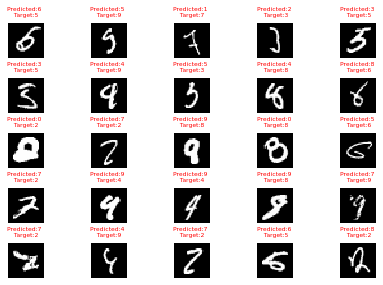

In [ ]:
model_temp = Net().to(device)
state_dict = torch.load('models/GBN.pth')
#print(state_dict.keys())
model_temp.load_state_dict(state_dict)
Batch_Norm='GBN'

if Batch_Norm=='BN':
  Batch_size = 128
else:
  Batch_size = 32

dataloader_args= dict(shuffle=True, batch_size=Batch_size,num_workers=4, pin_memory=True ) if use_cuda else dict(shuffle=True, batch_size=Batch_size)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

incorrect_images(model_temp, device, test_loader, Batch_Norm)

## Plot validation Accuracy across versions

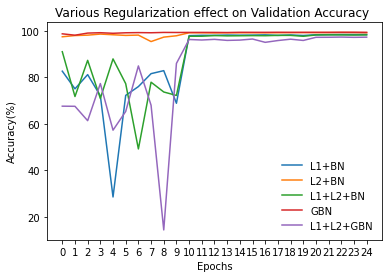

In [ ]:
val_acc.plot.line(title='Various Regularization effect on Validation Accuracy ',use_index =True).set(xlabel='Epochs',ylabel='Accuracy(%)',xticks=val_acc.index)
plt.legend(frameon=False)
#plt.legend
plt.savefig('models/val_acc.jpg')
plt.show()

## Plot validation Loss across versions

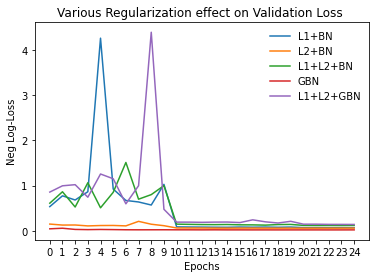

In [ ]:
val_loss.plot.line(title='Various Regularization effect on Validation Loss ',use_index =True).set(xlabel='Epochs',ylabel='Neg Log-Loss',xticks=val_acc.index)
plt.legend(frameon=False)
plt.savefig('models/val_loss.jpg')
plt.show()